In [1]:
import torch
import numpy as np
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


from pathlib import Path
from multiprocessing.pool import ThreadPool
import pickle

In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Feb  3 15:01:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2E:00.0 Off |                  N/A |
| N/A   48C    P8     8W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
# нормализация изображений
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
# пути к файлам
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset/')

### Объявление необходимых функций

In [4]:
# Выводит изображение
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит сканирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(MEAN, STD) 
        ])
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

### Загрузка и обработка данных

In [6]:
# Загружаем данные
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

# Разделяем данные на тренировочные и валидационные
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

### Выводим случайные изображения из валидационных данных

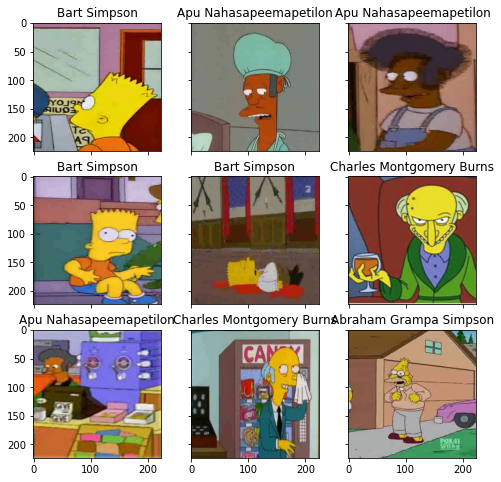

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

### Функции обучения модели

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Создание и обучение модели

In [20]:
n_classes = len(np.unique(train_val_labels))

my_model = models.vgg16_bn(pretrained=True).to(DEVICE)
my_model.classifier = nn.Linear(25088, n_classes)

if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

#Замораживаем параметры
for param in my_model.parameters():
    param.requires_grad = True

my_model = my_model.cuda()

In [27]:
!nvidia-smi

Thu Feb  3 15:05:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.23       Driver Version: 511.23       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2E:00.0 Off |                  N/A |
| N/A   48C    P8     4W /  N/A |   3830MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
history = train(train_dataset, val_dataset, model=my_model, epochs=5, batch_size=32)


epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 0.6441444983969631


epoch:  20%|██████████████▌                                                          | 1/5 [26:28<1:45:53, 1588.31s/it]


Epoch 001 train_loss: 0.6441     val_loss 0.2244 train_acc 0.8516 val_acc 0.9434
loss 0.23643140041044702


epoch:  40%|████████████████████████████▍                                          | 2/5 [1:00:21<1:32:30, 1850.01s/it]


Epoch 002 train_loss: 0.2364     val_loss 0.2155 train_acc 0.9409 val_acc 0.9490
loss 0.13072239756801293


epoch:  60%|██████████████████████████████████████████▌                            | 3/5 [1:30:45<1:01:16, 1838.21s/it]


Epoch 003 train_loss: 0.1307     val_loss 0.2257 train_acc 0.9669 val_acc 0.9515
loss 0.08079977573830349


epoch:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [1:58:34<29:31, 1771.51s/it]


Epoch 004 train_loss: 0.0808     val_loss 0.1928 train_acc 0.9786 val_acc 0.9562
loss 0.058445998136946904


epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [2:32:26<00:00, 1829.37s/it]


Epoch 005 train_loss: 0.0584     val_loss 0.1784 train_acc 0.9847 val_acc 0.9601


### Строим кривые обучения

In [ ]:
"""
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
"""

### Сохраняем результаты обучения модели

In [18]:
# Чтобы сохранить
#torch.save(my_model.state_dict(), 'trained_model.pt')
# Чтобы загрузить
#n_classes = len(np.unique(train_val_labels))
#my_model = models.vgg16_bn(pretrained=True).to(DEVICE)
#my_model.classifier = nn.Linear(25088, n_classes)
#my_model.load_state_dict(torch.load('trained_model.pt'))
#my_model = my_model.cuda()

### Определение точности

In [19]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [20]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_model, ex_img.unsqueeze(0))

In [21]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_model, imgs)

In [22]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [23]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

In [24]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'micro')

1.0

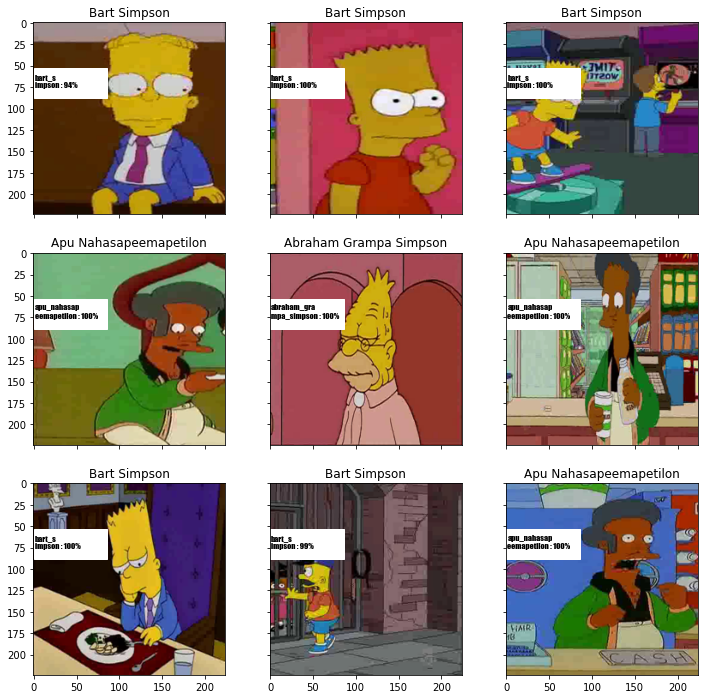

In [25]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [37]:
import pandas as pd
submission = pd.read_csv('./submission.csv')
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
submission.to_csv('./submission.csv', index=False)

In [38]:
submission

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,homer_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
